# Аналитика интернет-магазина

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Загрузка данных и подготовка их к анализу

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as stats
import numpy as np
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', -1)
pd.plotting.register_matplotlib_converters()

In [ ]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [ ]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [ ]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [ ]:
hypothesis.duplicated().sum()

0

In [ ]:
hypothesis.columns = hypothesis.columns.str.lower()

In [ ]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [ ]:
orders.duplicated().sum()

0

In [ ]:
orders['date'] = orders['date'].astype('datetime64[D]')
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [ ]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [ ]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [ ]:
visitors['date'] = visitors['date'].astype('datetime64[D]')

Посчитаем количество уникальных значений для каждого пользователя в каждой группе.<br>
В случае, если значение счетчика больше единицы, это будет означать, что пользователь попал в обе группы и мы запишем его id в отдельный список.

In [ ]:
group_count = orders.groupby('visitor_id').agg({'group' : 'nunique'}).reset_index()
group_count = group_count[group_count['group']>1]
visitors_in_both_groups = list(group_count['visitor_id'])
len(group_count['visitor_id'].unique())

58

In [ ]:
len(orders['visitor_id'].unique())

1031

58 пользователей попало в обе группы. 58 пользователей из 1031 - всего лишь 5 процентов от общего числа пользователей. Отфильтруем таблицу orders от пользователей, попавших в обе группы.

In [ ]:
orders = orders.query('visitor_id not in @visitors_in_both_groups')

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1016 non-null int64
visitor_id        1016 non-null int64
date              1016 non-null datetime64[ns]
revenue           1016 non-null int64
group             1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


### Вывод

- Названия столбцов приведены к нижнему регистру
- Пропуски в данных не обнаружены
- Дубликаты в данных не обнаружены
- Столбцы, содержащие в себе дату, приведены к типу данных datetime
- Определены пользователи, попавшие в обе группы, исходная таблица отфильтрована

## Приоритизация гипотез.

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета

In [ ]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'])
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [ ]:
hypothesis['RICE'] = (hypothesis['reach']* hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [ ]:
hypothesis[['hypothesis','ICE','RICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0,4.0


Применив фреймворк ICE, в качестве приоритетных гипотез выделили гипотезы:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Применив фреймворк RICE, в качестве приоритетных гипотез выделили гипотезы:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
<br><br>
Такие различия в приоритетах объясняются тем, что в первом случае, мы не учитывали параметр охвата пользователей Reach.

## Анализ A/B-теста

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [ ]:
datesGroups = orders[['date','group']].drop_duplicates() 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


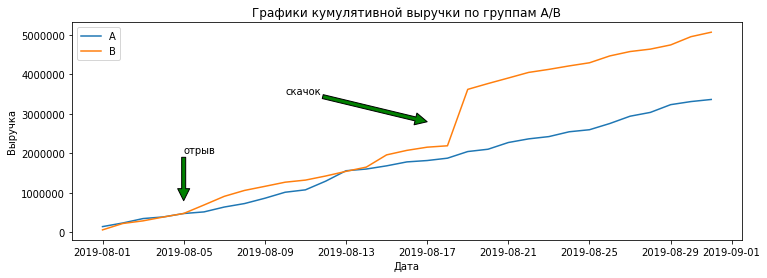

In [ ]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))
plt.show()

До 5 августа кумулятивная выручка по обоим сегментам практически равна. С 5 августа группа B вырывается вперед по кумулятивной выручке, причем с 18-19 августа у группы B происходит резкий скачок, и до конца теста группа B продолжает лидировать.

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

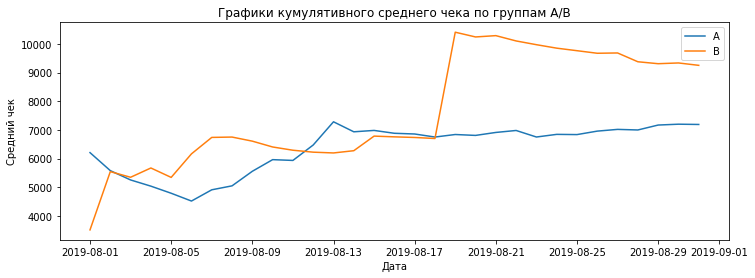

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.legend()
plt.show()

Средний чек группы B почти все время был выше, чем средний чек группы A, лишь 13 августа группа A немного вырывается вперед. Опять же с 18-19 августа наблюдаем резкий скачок у группы B, как на графике кумулятивной выручки. Возможно, это обусловлено аномалиями, необходимо это выяснить при дальнейшем анализе.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

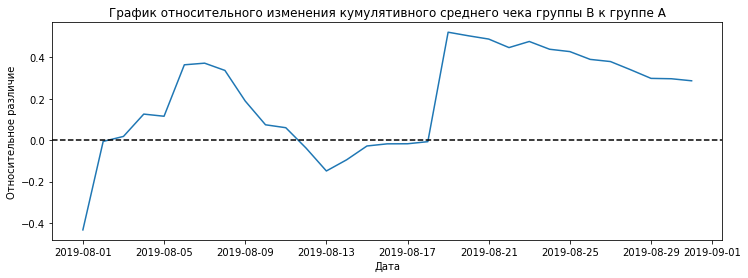

In [ ]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,4))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное различие')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Результаты теста значительно резко менялись в нескольких точках (13 августа, 18-19 августа) - в дальнейшем необходимо рассмотреть выбросы в данных.

### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

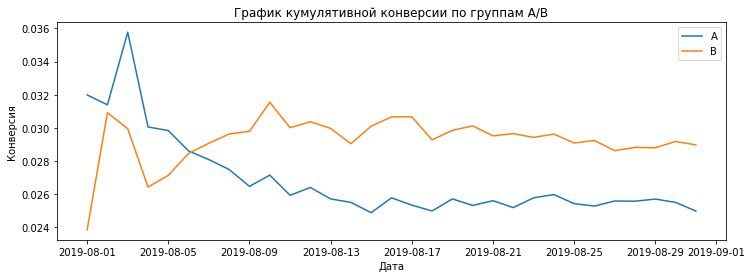

In [ ]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам A/B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()

Начиная с 6 августа, конверсия группы B вырвалась вперед, а конверсия группы A просела.

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

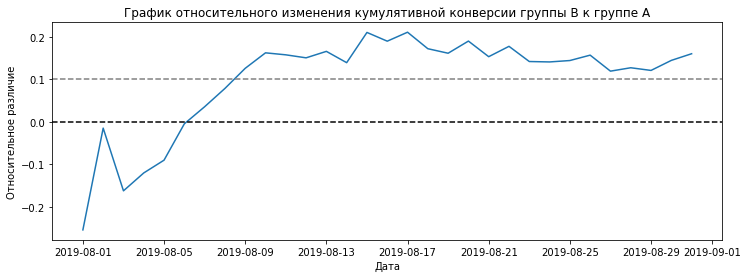

In [ ]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,4))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.ylabel('Относительное различие')
plt.xlabel('Дата')
plt.show()

По просшествии недели, примерно с 7 августа, конверсия группы B стабильно выше конверсии группы A.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

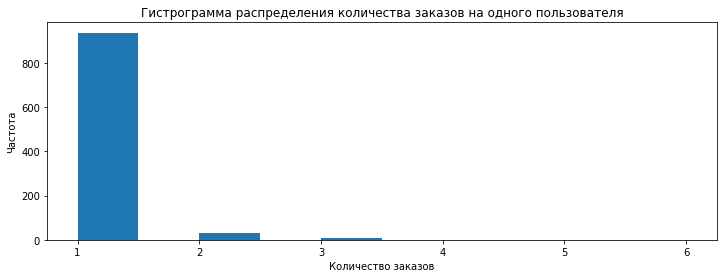

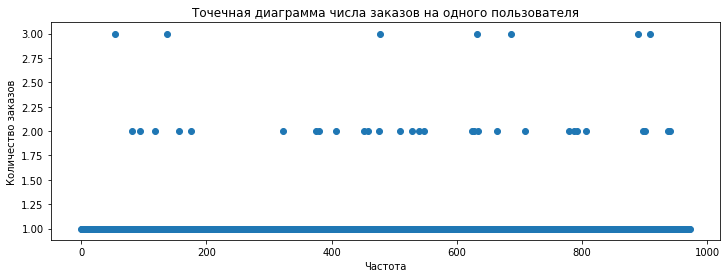

In [ ]:
ordersByUsers = (
    orders
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

plt.figure(figsize=(12,4))
plt.hist(ordersByUsers['orders'], range=(1,6), bins = 10)
plt.title('Гистрограмма распределения количества заказов на одного пользователя')
plt.ylabel('Частота')
plt.xlabel('Количество заказов')
plt.show()

x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(12,4))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.ylabel('Количество заказов')
plt.xlabel('Частота')
plt.show()

Чаще всего пользователи совершают 1 или 2 заказа. Реже больше 2 заказов.

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [ ]:
percentiles = np.percentile(ordersByUsers['orders'], [95, 99])
print('95 перцентиль: {}'.format(percentiles[0]))
print('99 перцентиль: {}'.format(percentiles[1]))

95 перцентиль: 1.0
99 перцентиль: 2.0


Не более 5% пользователей совершают больше 1 заказа и не более 1% больше 2 заказов.<br>
В качестве границы определения аномальных пользователей возьмем значение в 1 заказ.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

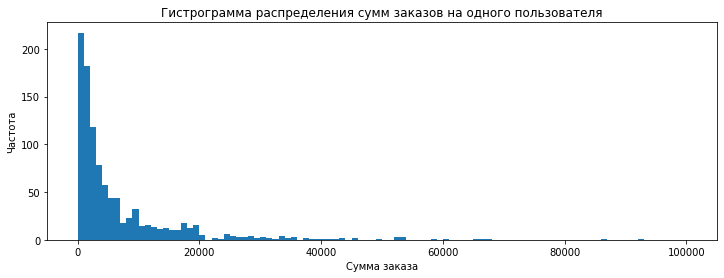

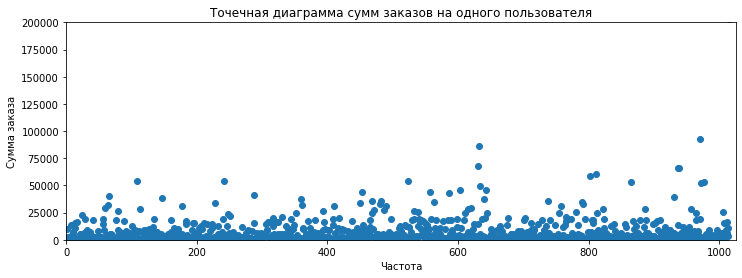

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(orders['revenue'], range=(0,100000), bins = 100)
plt.title('Гистрограмма распределения сумм заказов на одного пользователя')
plt.ylabel('Частота')
plt.xlabel('Сумма заказа')
plt.show()
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(12,4))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Сумма заказа')
plt.xlabel('Частота')
plt.axis([0, 1025, 0, 200000])
plt.title('Точечная диаграмма сумм заказов на одного пользователя')
plt.show()

Проанализировав графики, можно сделать вывод, что большая часть пользователей совершает покупки на сумму не больше 25-30 тысяч рублей.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [ ]:
percentiles = np.percentile(orders['revenue'], [95, 99])
print('95 перцентиль: {:.0f}'.format(percentiles[0]))
print('99 перцентиль: {:.0f}'.format(percentiles[1]))

95 перцентиль: 26785
99 перцентиль: 53904


Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей.<br>
В качестве границы определения аномальных заказов возьмем значение в 26785 рублей.

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

Для тестирования гипотез применим тест Уилкоксона-Манна-Уитни, так как в данных присутствуют выбросы, а данный тест работает с рангами, не учитывая сами значения.

Нулевая гипотеза:  Cтатистически значимых различий в конверсии между группами по "сырым данным" нет. <br>
Альтернативная гипотеза: Cтатистически значимые различия в конверсии между группами "сырым данным" есть.

Критерий значимости или уровень достоверности для всех последующих тестов определим как 0,05 (5%). Таким образом при проверке статистических гипотез вероятность совершить ошибку первого рода, то есть отвергнуть истинную нулевую гипотезу, будет равна 5%.

In [ ]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
ordersByUsersA.columns = ['visitor_id', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
ordersByUsersB.columns = ['visitor_id', 'orders']


sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = 0.05

print('Относительный прирост конверсии группы B по отношению к группе A: {:.3f}'.format(sampleB.mean()/sampleA.mean()-1))
print('P-value: {0:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
if (stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительный прирост конверсии группы B по отношению к группе A: 0.160
P-value: 0.01102
Отвергаем нулевую гипотезу


По сырым данным различия в конверсии между группами статистически значимы.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Нулевая гипотеза:  Cтатистически значимых различий в cреднем чеке заказа между группами по "сырым данным" нет. <br>
Альтернативная гипотеза: Cтатистически значимые различия в cреднем чеке заказа между группами по "сырым данным" есть.

In [ ]:
print('Относительный прирост среднего чека группы B по отношению к группе A: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
print('P-value: {0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],alternative = 'two-sided')[1], alternative = 'two-sided'))
if (stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],alternative = 'two-sided')[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительный прирост среднего чека группы B по отношению к группе A: 0.287
P-value: 0.82949
Не получилось отвергнуть нулевую гипотезу


Отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке заказа между группами по сырым данным не можем.

Протестируем гипотезы на очищенных данных и сравним результаты тестов.

### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения

In [ ]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

Нулевая гипотеза: Cтатистически значимых различий в конверсии между группами по очищенным данным нет. <br>
Альтернативная гипотеза: Cтатистически значимые различия в конверсии между группами по очищенным данным" есть.

In [ ]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('Относительный прирост конверсии группы B по отношению к группе A по очищенным данным: {:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
print('P-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered,  alternative = 'two-sided')[1]))
if (stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительный прирост конверсии группы B по отношению к группе A по очищенным данным: 0.174
P-value: 0.01593
Отвергаем нулевую гипотезу


В обоих случаях, как при проверке статистической значимости по "сырым данным", так и при проверке по очищенным данным, отвергаем нулевую гипотезу об отсутствии статистически значимых различий в конверсии между группами.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Нулевая гипотеза:  Cтатистически значимых различий в cреднем чеке заказа между группами по очищенным данным нет. <br>
Альтернативная гипотеза: Cтатистически значимые различия в cреднем чеке заказа между группами по очищенным данным есть.

In [ ]:
print(
    'Относительный прирост среднего чека группы B по отношению к группе A по очищенным данным: {0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

print(
    'P-value: {0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],alternative = 'two-sided'
        )[1]
    )
)

if (stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],alternative = 'two-sided'
        )[1] < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Относительный прирост среднего чека группы B по отношению к группе A по очищенным данным: -0.034
P-value: 0.72713
Не получилось отвергнуть нулевую гипотезу


В обоих случаях, как при проверке статистической значимости по "сырым данным", так и при проверке по очищенным данным, не можем отвергнуть нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке заказа между группами по сырым данным.

### Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Кумулятивные выручка, конверсия и средний чек лидируют в группе B. Сомнения вызывали лишь резкие скачки на графиках.<br>Поэтому определили аномальных пользователей и проверили гипотезы по "cырым" и очищенным данным. Как до, так и после очистки данных от выбросов, определили, что различия в конверсии между группами статистически значимы, несмотря на отсутствие статистически значимых различий в среднем чеке заказа между группами. 

Таким образом, тест можно остановить и зафиксировать победу группы B.

## Выводы

- Данные загружены и проанализированы
- Ознакомившись с данными, не выявили наличие пропусков и дубликатов
- Столбцы, содержащие в себе дату, приведены к типу данных datetime
- Определены пользователи, попавшие в обе группы, исходная таблица отфильтрована
<br><br>
- Приоритезировали гипотезы, применив фреймворки ICE и RICE. Отметили, что так как фреймворк RICE учитывает параметр охвата пользователей Reach, приоритеты гипотез, полученные по ICE, изменились. 
- Проанализировав график кумулятивной выручки, делаем вывод, что несмотря на то, что в начале теста кумулятивная выручка по обоим сегментам практически равна, группа B в дальнейшем вырывается вперед, причем с 18-19 августа у группы B происходит резкий скачок, и до конца теста группа B продолжает лидировать.
- Проанализировав график кумулятивного среднего чека по группам, делаем вывод, что средний чек группы B почти все время был выше, чем средний чек группы A, лишь 13 августа группа A немного вырывается вперед. Опять же с 18-19 августа наблюдаем резкий скачок у группы B, как на графике кумулятивной выручки.
- Проанализировав график относительного изменения кумулятивного среднего чека группы B к группе A, делаем вывод, что большая часть графика все-таки находится выше горизонтальной оси, что может значит, что средний чек группы B выше, чем средний чек группы A. Однако, результаты теста значительно резко менялись в нескольких точках.
- Изучив графики кумулятивной конверсии по группам и относительного изменения кумулятивной конверсии группы B к группе A, делаем вывод, что конверсия группы B стабильно выше конверсии группы A.
- Определили границы аномальных пользователей для дальнейшего подсчета статистической значимости по очищенным данным. В качестве границ определили значение в 2 заказа на пользователя, значение стоимости заказа в 27570 рублей.
<br><br>
Кумулятивные выручка, конверсия и средний чек по результатам анализа лидируют в группе B. Сомнения вызывали лишь резкие скачки на графиках. Определили аномальных пользователей и проверили гипотезы по "cырым" и очищенным данным. Как до, так и после очистки данных от выбросов, определили, что различия в конверсии между группами статистически значимы, несмотря на отсутствие статистически значимых различий в среднем чеке заказа между группами. 
<br><br>
Таким образом, тест остановили и зафиксировать победу группы B.